# Previously...
We have done our EDA on the SPAM / HAM mail dataset. There we cleared the data and worked on it to explore what it tells us and what can we do about it.

Now, here in this *notebook* we will expand our project further and will create an ML model which can classify a mail is spam or ham based on the learnt charecteristics. As usual, we will set the ***goals*** for this book.
<br>—<br>
### **Goals**:
- Make data in a ML usable format
    - Onehot Encode
    - Scale Numbers if needed
    - Use TF/IDF on the bag of words
- Try different models
    - KNN
    - Logistic Regression
    - SGD Classifier
    - SVM
- Make pipeline for the transformations (possibly manual transformer)
- Pick the 2 potential best models and hypertune them
- Make a learning curve
- Make ROC curve
- Interpret ROC curve
- Interpret confusion metrics

**I think this will be enough** to get us goting.<br>
Let's get started ∞

In [231]:
# Usual imports 
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

# Model imports
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Pipeline imports
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Evaluation imports
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve

# Preprocessing imports
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer

# Hypertuning imports
from sklearn.model_selection import GridSearchCV

# Textual imports
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## `•` Preprocessing

In [4]:
df = pd.read_csv("BEST.csv", parse_dates=["datetime"])

###### 

**Domain Extraction** *(Recall from EDA - the domain name from email was quite a good feature)*

In [8]:
df.server_mail = df.server_mail.str.partition("@")[2]

In [12]:
df.from_mail = df.from_mail.str.partition("@")[2]

**Datetime Drop** *(Recall from EDA - the datetime feature was not a good feature)*

In [16]:
df.drop("datetime", axis=1, inplace=True)

**Subject Drop** *(Recall from EDA - the subject of mail feature was not a good feature)*

In [18]:
df.drop("subject", axis=1, inplace=True)

**Topic Drop** *(We took **topic** as an analysis feature, so we don't need it here — we have whole message body!)*

In [20]:
df.drop("topic", axis=1, inplace=True)

Now finally our dataset looks good. We now need to make a pipeline to make some preprocessing steps like *punctuation removal, lemmatization, and you know those stuff*.

In [22]:
df.sample(6)

,server_mail,from_mail,message,label,n_nouns
1627,lists.sourceforge.net,zurich.ai.mit.edu,emacs rmail varieties different techniques sor...,ham,236
1334,freshrpms.net,rpmforge.net,upon time brian write fresh new 80 install id ...,ham,497
2380,jmason.org,example.com,url httpwwwnewsisfreecomclick585535381440 date...,ham,65
2960,insiq.us,insiq.us,multipart message mime format nextpart000c16f3...,spam,1667
2984,home-based-business.de,home-based-business.de,hello may see business ignore know many time h...,spam,4962
2146,jmason.org,example.com,url httpwwwnewsisfreecomclick08357896215 date ...,ham,48


**NOTE**: Here I will take care of the ***Curse of Dimentionality*** concept. As we will one hot encode other features like *server_mail* and *from_mail*, there will be a huge sparce metrix of 0 and 1s along with another gigantic sparse matrix of our main *message* feature. So I might drop some feature later if needed.


In [154]:
# Making features dynamic, so one change will
#  impact in others as well.
numerical = ["n_nouns"]
categorical = ["server_mail", "from_mail"]
main_ft = ["message"]

features_all = numerical + categorical + main_ft
features = {"numerical": numerical,
            "categorical": categorical,
            "main_ft": main_ft}
target = "label"

In [108]:
idx = [9, 10, 11, 12, 22, 27, 41, 145, 147, 149,
               151, 153, 155, 157, 159, 162, 164, 166,
               168, 170, 172, 174, 176, 178]
        
stopwords_ = stopwords.words("english")
tobeadded = re.sub("'", "", " ".join(np.array(stopwords_)[idx])).split()
tobeadded = tobeadded + ["u", "r", "dont", "2002", "date"]
stopwords_ = stopwords_ + tobeadded

In [126]:
def clean_message(msg):
    # Make it low
    msg = msg[0]
    msg = msg.lower()

    # Removing puncs
    msg = replacer.sub("", msg)

    # Removing stops
    msg = [word for word in msg.split() if word not in stopwords_]

    # Lemmitizing
    msg = [lemma.lemmatize(word, pos="v") for word in msg]
    
    # Here, we won't need to join. 
    return msg

In [141]:
num_pipe = Pipeline([
                ("imputer", SimpleImputer()),
                ("scaler", StandardScaler())
            ])

cat_pipe = Pipeline([
                ("impuer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown='ignore'))
            ])

msg_pipe = Pipeline([
                ("impuer", SimpleImputer(strategy="most_frequent")),
                ("tfidf", TfidfVectorizer(analyzer=clean_message))
            ])

In [142]:
transformer = ColumnTransformer([
                ("num_transformer", num_pipe, features["numerical"]),
                ("cat_transformer", cat_pipe, features["categorical"]),
                ("msg_transformer", msg_pipe, features["main_ft"])
            ])

In [171]:
X = df.drop(target, axis=1)
y = df[target]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

In [173]:
Xtrain = transformer.fit_transform(Xtrain)
Xtest = transformer.transform(Xtest)

In [174]:
Xtrain

<2135x40010 sparse matrix of type '<class 'numpy.float64'>'
	with 203318 stored elements in Compressed Sparse Row format>

In [175]:
Xtest

<916x40010 sparse matrix of type '<class 'numpy.float64'>'
	with 77893 stored elements in Compressed Sparse Row format>

Cool! Now our data has `40010` features!

### 

## `•` Try different models

In [187]:
for model in [LogisticRegression(), SVC(), KNeighborsClassifier(n_neighbors=3), SGDClassifier()]:
    print(model, end="\n---\n")
    model.fit(Xtrain, ytrain)
    pred = model.predict(Xtest)
    print("Acc: \n", accuracy_score(ytest, pred))
    print("\nConf: \n", confusion_matrix(ytest, pred))
    print("\n\n")

LogisticRegression()
---
Acc: 
 0.980349344978166

Conf: 
 [[756   3]
 [ 15 142]]



SVC()
---
Acc: 
 0.9836244541484717

Conf: 
 [[756   3]
 [ 12 145]]



KNeighborsClassifier(n_neighbors=3)
---
Acc: 
 0.9814410480349345

Conf: 
 [[759   0]
 [ 17 140]]



SGDClassifier()
---
Acc: 
 0.9934497816593887

Conf: 
 [[755   4]
 [  2 155]]





#### Amazing! Every model is giving freakin' awsome accuracy!

0 → HAM  
1 → SPAM

From all confusion metrices, we can see that all of our models are giving high False Negative values than False Positive values. Which denotes that many messages which were SPAMS we predicted them as HAMS.

In some model like KNN, there are `0` False Positives but `17` False Negatives. Which may or may not be a tolerable thing.<br>

— Now, after looking at the models' performance - I would put my choice on `SGDClassifier` and `SVC`. They are *top performing* models with the default settings. So now, we can go ahead and do some hypertuning.

But at the end, I also want to make the ROC curve, so to compare models for demonstration purposes, we are ***instead of*** using **2** models, we will hypertune **all** 4 models. And then compare their ROC curves with the **best** possible hyperparameters.

###### 

## `•` Hypertuning

```python
# Logistic Params
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
```

In [190]:
param_grid_log_reg = dict(tol=[0.01, 0.00001],
                          max_iter=[200, 300, 500],
                          warm_start=[True, False])

```python
# SGD Params
    loss='hinge',
    *,
    penalty='l2',
    alpha=0.0001,
    l1_ratio=0.15,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    verbose=0,
    epsilon=0.1,
    n_jobs=None,
    random_state=None,
    learning_rate='optimal',
    eta0=0.0,
    power_t=0.5,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    class_weight=None,
    warm_start=False,
    average=False,
```

In [192]:
param_grid_SGD_clf = dict(loss=["log", "squared_loss", "hinge", "squared_hinge"],
                          max_iter=[1000, 2000, 5000, 10000],
                          tol=[0.01, 0.0001, 0.00001],
                          eta0=[0.01, 0.0001, 0.3],
                          early_stopping=[True, False])

```python
# KNN    
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None
```

In [200]:
param_grid_KNN = dict(n_neighbors=[1, 2, 3, 5, 9, 10, 11],
                      p=[1, 2, 0.5])

```python
# SVC
    C=1.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=None,
```

In [201]:
param_grid_SVC = dict(C=np.arange(1, 50, 3),
                      kernel=["rbf", "poly", "sigmoid"],
                      degree=[2, 3, 4])

In [ ]:
models = [KNeighborsClassifier(), LogisticRegression(), SGDClassifier(), SVC()]
grids = [param_grid_KNN, param_grid_log_reg, param_grid_SGD_clf, param_grid_SVC]

results = []
for model, grid in zip(models, grids):
    print(model)
    GSCV = GridSearchCV(model, grid, verbose=3, scoring="accuracy")
    GSCV.fit(Xtrain, ytrain)
    results.append(GSCV.cv_results_)
    print("--\n\n")

In [205]:
KNN_res = pd.DataFrame(results[0])
Log_res = pd.DataFrame(results[1])
SGD_res = pd.DataFrame(results[2])
SVC_res = pd.DataFrame(results[3])

In [208]:
KNN_res.sort_values(by="rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.003727,0.006063,0.034956,0.006064,1,2,"{'n_neighbors': 1, 'p': 2}",0.976581,0.976581,0.976581,0.992974,0.983607,0.981265,0.006456,1


In [211]:
Log_res.sort_values(by="rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,param_tol,param_warm_start,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.231945,0.124484,0.000401,0.000803,200,0.01,True,"{'max_iter': 200, 'tol': 0.01, 'warm_start': T...",0.967213,0.974239,0.967213,0.962529,0.976581,0.969555,0.005131,1


In [212]:
SGD_res.sort_values(by="rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_early_stopping,param_eta0,param_loss,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
275,0.009296,0.00531,0.000602,0.000491,False,0.3,hinge,10000,1e-05,"{'early_stopping': False, 'eta0': 0.3, 'loss':...",0.983607,0.98829,0.98829,0.990632,0.983607,0.986885,0.00281,1


In [213]:
SVC_res.sort_values(by="rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,1.01154,0.052466,0.244295,0.017807,13,3,rbf,"{'C': 13, 'degree': 3, 'kernel': 'rbf'}",0.976581,0.983607,0.983607,0.990632,0.985948,0.984075,0.004541,1


The third split always gives the better result. Let's use all those hyperparams and train it in whole Xtrain.

In [222]:
KNN_params = KNN_res.sort_values(by="rank_test_score").head(1)["params"].values.flatten()[0]
Log_params = Log_res.sort_values(by="rank_test_score").head(1)["params"].values.flatten()[0]
SGD_params = SGD_res.sort_values(by="rank_test_score").head(1)["params"].values.flatten()[0]
SVC_params = SVC_res.sort_values(by="rank_test_score").head(1)["params"].values.flatten()[0]

In [227]:
SVC_params

{'C': 13, 'degree': 3, 'kernel': 'rbf'}

In [226]:
for model in [KNeighborsClassifier(**KNN_params), LogisticRegression(**Log_params), 
            SGDClassifier(**SGD_params), SVC(**SVC_params)]:
    print(model)
    model.fit(Xtrain, ytrain)
    pred = model.predict(Xtest)
    print("Acc: \n", accuracy_score(ytest, pred))
    print("\nConf: \n", confusion_matrix(ytest, pred))
    print("\n\n")

KNeighborsClassifier(n_neighbors=1)
Acc: 
 0.9890829694323144

Conf: 
 [[759   0]
 [ 10 147]]



LogisticRegression(max_iter=200, tol=0.01, warm_start=True)
Acc: 
 0.980349344978166

Conf: 
 [[756   3]
 [ 15 142]]



SGDClassifier(eta0=0.3, max_iter=10000, tol=1e-05)
Acc: 
 0.990174672489083

Conf: 
 [[756   3]
 [  6 151]]



SVC(C=13)
Acc: 
 0.9912663755458515

Conf: 
 [[756   3]
 [  5 152]]





Amazing! ***Except*** Logistic and KNN the ***rest are giving*** `99% +` accuracy!

# `•` Make a learning curve

In [247]:
models = [KNeighborsClassifier(**KNN_params), LogisticRegression(**Log_params), 
             SGDClassifier(**SGD_params), SVC(**SVC_params)]

m_names = ["KNN", "Logistic Regression", "SGD Classifier", "SVC"]

def get_lc(th, ax):
    N, train_lc, val_lc = learning_curve(models[th], Xtrain, ytrain, train_sizes=[.01, .05, .10, .25, .50, .60, .75, .90, 1])

    ax.plot(N, np.mean(train_lc, 1), label="Training Curve")
    ax.plot(N, np.mean(val_lc, 1), label="Validation Curve")
    ax.set_title(f"{m_names[th]}'s Learning Curve")
    ax.legend();

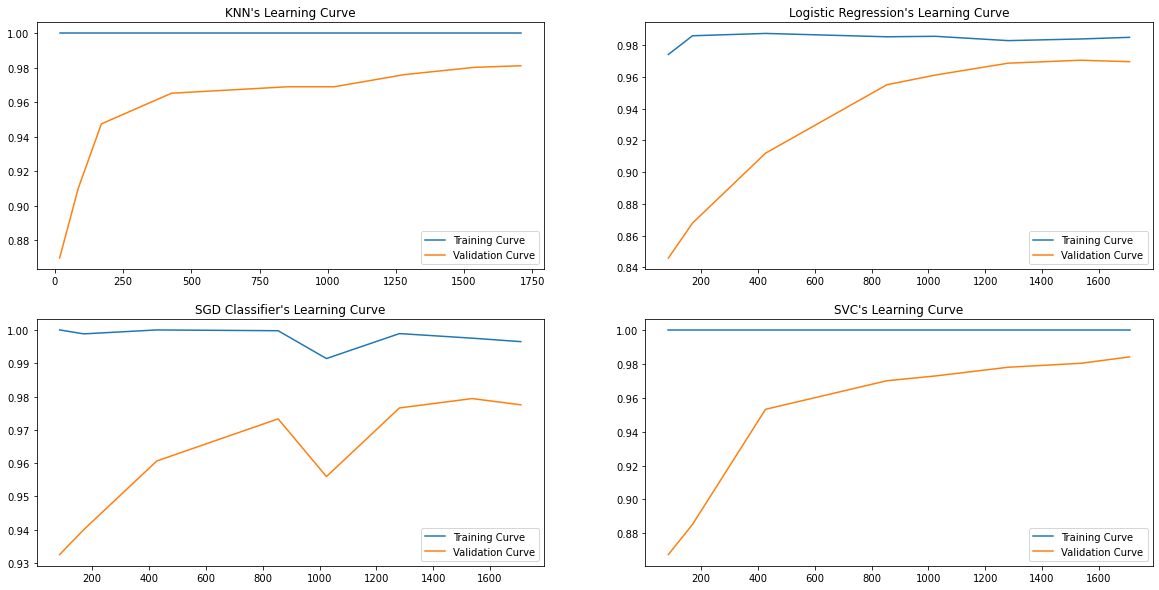

In [251]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
get_lc(0, axes[0][0])
get_lc(1, axes[0][1])
get_lc(2, axes[1][0])
get_lc(3, axes[1][1])

Of course, the more data, the better accuracy. 

###### 

# `•` Make ROC curve

In [259]:
preds = []
for th, model in enumerate([KNeighborsClassifier(**KNN_params), LogisticRegression(**Log_params), 
                                SGDClassifier(**SGD_params), SVC(**SVC_params, probability=True)]):
    model.fit(Xtrain, ytrain)
    if not th == 2:
        preds.append(model.predict_proba(Xtest))
    else:
        preds.append(model.decision_function(Xtest))

Actually, to get the ROC curve with SGD Model, the `loss="hinge"` is not supported to return the probabilities. So we will use the `decision_function` there. 

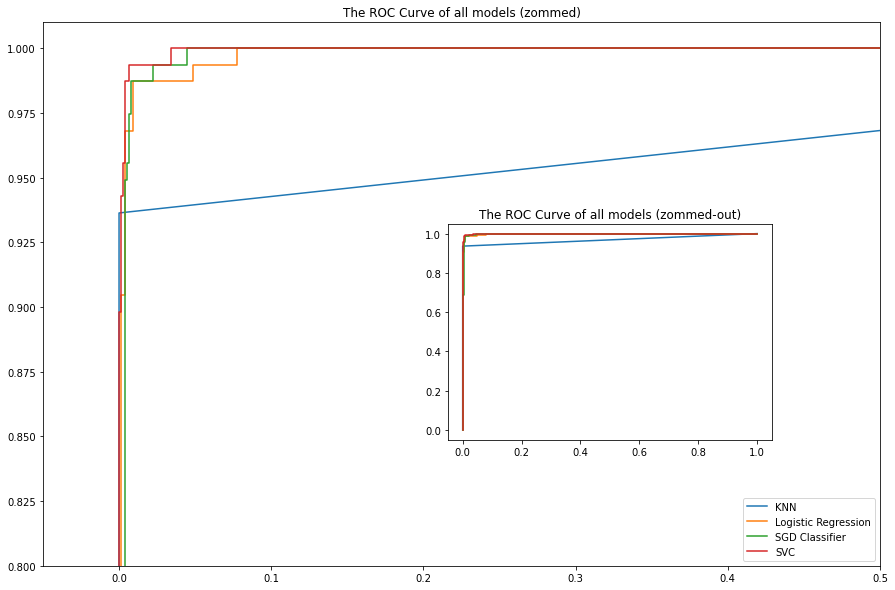

In [306]:
fig = plt.figure(figsize=(15, 10))

main_ax = plt.axes()
subplot = fig.add_axes([.5, .3, .3, .3])

fpr, tpr, thresh = roc_curve(pd.Categorical(ytest).codes, preds[0][:, 1])
main_ax.plot(fpr, tpr, label=m_names[0])
subplot.plot(fpr, tpr, label=m_names[0])

fpr, tpr, thresh = roc_curve(pd.Categorical(ytest).codes, preds[1][:, 1])
main_ax.plot(fpr, tpr, label=m_names[1])
subplot.plot(fpr, tpr, label=m_names[0])

fpr, tpr, thresh = roc_curve(pd.Categorical(ytest).codes, preds[2])
main_ax.plot(fpr, tpr, label=m_names[2])
subplot.plot(fpr, tpr, label=m_names[0])

fpr, tpr, thresh = roc_curve(pd.Categorical(ytest).codes, preds[3][:, 1])
main_ax.plot(fpr, tpr, label=m_names[3])
subplot.plot(fpr, tpr, label=m_names[0])

main_ax.set_ylim([0.8, 1.01])
main_ax.set_xlim([-0.05, .5])
main_ax.set_title("The ROC Curve of all models (zommed)")
subplot.set_title("The ROC Curve of all models (zommed-out)")
main_ax.legend();

Overall the SVC's ROC curve's AUC is higher than all of the others. So, you know... we can **decalare SVC** as the **WINNER** 

In [321]:
SVC_params

{'C': 13, 'degree': 3, 'kernel': 'rbf'}

# <center> 🎉 SVC is the WINNER 🎉 </center>

# `•` Make PR curve

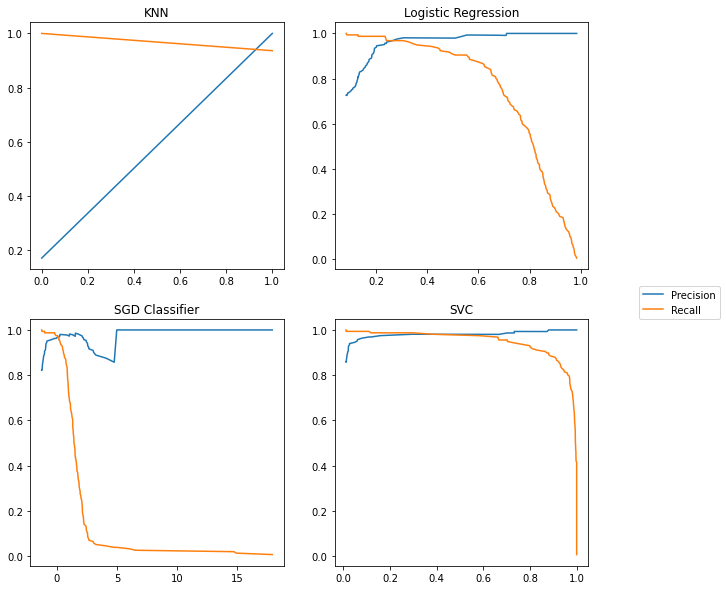

In [320]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

pre, re, thresh = precision_recall_curve(pd.Categorical(ytest).codes, preds[0][:, 1])
axes[0].plot(thresh, pre[:-1])
axes[0].plot(thresh, re[:-1])
axes[0].set_title(m_names[0])

pre, re, thresh = precision_recall_curve(pd.Categorical(ytest).codes, preds[1][:, 1])
axes[1].plot(thresh, pre[:-1])
axes[1].plot(thresh, re[:-1])
axes[1].set_title(m_names[1])

pre, re, thresh = precision_recall_curve(pd.Categorical(ytest).codes, preds[2])
axes[2].plot(thresh, pre[:-1])
axes[2].plot(thresh, re[:-1])
axes[2].set_title(m_names[2])

pre, re, thresh = precision_recall_curve(pd.Categorical(ytest).codes, preds[3][:, 1])
axes[3].plot(thresh, pre[:-1], label="Precision")
axes[3].plot(thresh, re[:-1], label="Recall")
axes[3].set_title(m_names[3])

plt.legend(loc=[1.2, 1]);

Here, if we want to choose SVM we will choose ~ `0.4` as our threshold value.

# 

# Amazing!
We did it! The accuracy is above `99%` in the final SVC model.

Thanks for reading this far! <br>
Aayush **∞** Shah